In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [9]:
# Run Noise_process before run this file
def get_dataset(obj_name):
    filename_labels = 'train_labels.npy'
    filename_origin = 'origin_cifar10.npy'
    filename_small_noise = 'small_noise_cifar10.npy'
    filename_medium_noise = 'medium_noise_cifar10.npy'
    filename_large_noise = 'large_noise_cifar10.npy'
    
    train_set = None
    match obj_name:
        case 'origin':
            train_set = np.load(filename_origin)
        case 'small_noise':
            train_set = np.load(filename_small_noise)
        case 'medium_noise':
            train_set = np.load(filename_medium_noise)
        case 'large_noise':
            train_set = np.load(filename_large_noise)
        case _:
            raise ValueError(f"Unknown obj_name: {obj_name}")
    label_set = np.load(filename_labels) if train_set.size > 0 else None

    if label_set is None or train_set is None:
        print("Run Noise_process.ipynb before run this file")
    return train_set, label_set

In [10]:
ORIGIN='origin'
SMALL='small_noise'
MEDIUM='medium_noise'
LARGE='large_noise'
all_dataset = [ORIGIN, SMALL, MEDIUM, LARGE]

In [11]:
# CNN: learning_rate, num_filter, filter_size
best_config_origin_cnn={'name': ORIGIN, 'num_filter': 128}
best_config_small_cnn={'name': SMALL, 'num_filter': 64}
best_config_medium_cnn={'name': MEDIUM, 'num_filter': 128}
best_config_large_cnn={'name': LARGE, 'num_filter': 128}
best_config_cnn=[]
best_config_cnn.append(best_config_origin_cnn)
best_config_cnn.append(best_config_small_cnn)
best_config_cnn.append(best_config_medium_cnn)
best_config_cnn.append(best_config_large_cnn)

Build Model

In [12]:
def build_simple_cnn(num_filter, learning_rate=0.0005, filter_size=(3,3), input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  
    model.add(layers.Conv2D(num_filter, filter_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def get_processed_dataset(model_name):
    train_set, label_set = get_dataset(model_name)

    X_combined_reshaped = train_set.reshape(-1, 32, 32, 3)
    X_combined_reshaped = X_combined_reshaped.astype('float32') / 255.0
    y_combined_categorical = to_categorical(label_set, num_classes=10)

    return X_combined_reshaped, y_combined_categorical

In [14]:
def plot_learning_curves(all_history, model_name):
    train_loss = np.mean([h['loss'] for h in all_history], axis=0)
    val_loss = np.mean([h['val_loss'] for h in all_history], axis=0)
    train_accuracy = np.mean([h['accuracy'] for h in all_history], axis=0)
    val_accuracy = np.mean([h['val_accuracy'] for h in all_history], axis=0)

    plt.figure(figsize=(24, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss Curve {model_name} CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy Curve {model_name} CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

Fold 1/20
Fold 2/20
Fold 3/20
Fold 4/20
Fold 5/20
Fold 6/20
Fold 7/20
Fold 8/20
Fold 9/20
Fold 10/20
Fold 11/20
Fold 12/20
Fold 13/20
Fold 14/20
Fold 15/20
Fold 16/20
Fold 17/20
Fold 18/20
Fold 19/20
Fold 20/20


AttributeError: 'list' object has no attribute 'history'

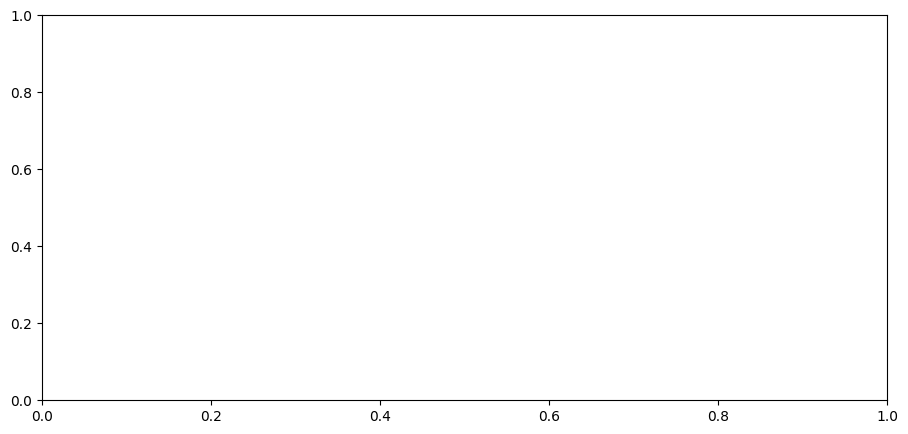

In [16]:
all_performance_cnn = {}
all_histories = {}
for config in best_config_cnn:
    model_name = config['name']
    model = build_simple_cnn(config['num_filter'])

    model_performance = {}
    
    # Use 80% for cross validation and 20% for robustness test for other model
    x_processed, y_processed = get_processed_dataset(model_name)
    x_cv, _, y_cv, _ = train_test_split(x_processed, y_processed, test_size=0.2, random_state=42)

    # Cross Validation
    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    all_history = []

    for fold, (train_index, val_index) in enumerate(kf.split(x_cv)):
        print(f'Fold {fold + 1}/{20}')

        x_train, x_val = x_cv[train_index], x_cv[val_index]
        y_train, y_val = y_cv[train_index], y_cv[val_index]

        history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val), verbose=0)

        all_history.append(history.history)

    plot_learning_curves(all_history, model_name)
    all_histories[model_name] = all_history

    # Release Memory Space
    del x_processed, y_processed, x_cv, y_cv

    # Robustness Test
    for dataset_name in all_dataset:
        if dataset_name == model_name:
            # Do robustness evaluations on other dataset
            continue
        # Get rest part of dataset which never used on Cross Validation
        x_evaluated, y_evaluated = get_processed_dataset(dataset_name)
        _, x_test, _, y_test = train_test_split(x_evaluated, y_evaluated, test_size=0.2, random_state=42)

        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1) 

        accuracy = accuracy_score(y_true_classes, y_pred_classes, average='weighted')
        precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
        recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

        print(f"Run {model_name}, in {dataset_name}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
        model_performance[dataset_name] = {'accuracy' : accuracy, 'precision' : precision, 'recall' : recall}
    all_performance_cnn[model_name] = model_performance



